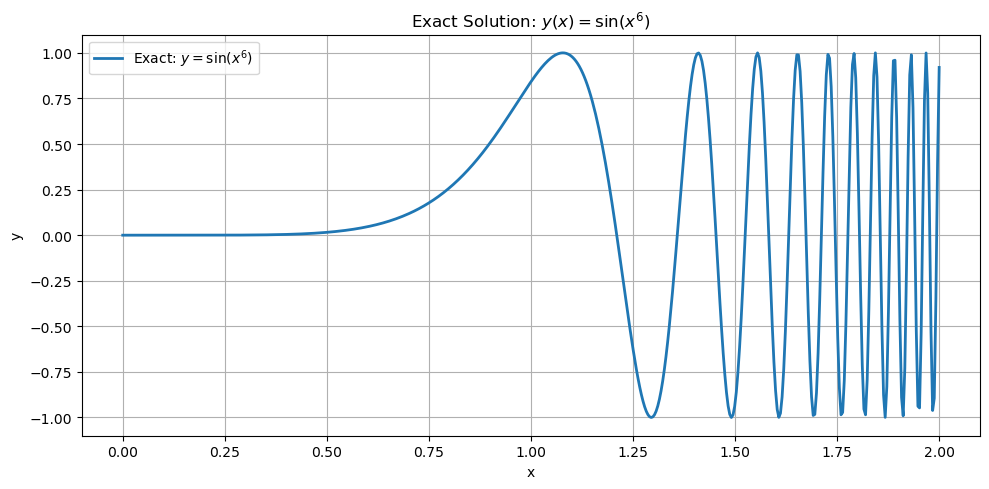

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

x = jnp.linspace(0, 2, 500)

# exact y = sin(x^5)
y = jnp.sin(x**6)

plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Exact: $y=\\sin(x^6)$', linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact Solution: $y(x) = \\sin(x^6)$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Uniform domain decomposition
n_sub = 2

In [ ]:
import os
import sys
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# Optional: Add project root to PYTHONPATH if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from utils.data_utils import generate_subdomain, generate_collocation_points
from utils.window_function import my_window_func
from model.fbpinn_model import FBPINN
from train.trainer_fbpinn import train_fbpinn
from physics.problems import SineX6ODE as pde_module

problem = pde_module()  # 实例化，绑定self
pde_residual_loss = problem.residual  
u_exact = problem.exact
ansatz = problem.ansatz
domain = problem.domain

# Training hyperparameters
steps = 20000
lr = 1e-3
n_sub = 2
overlap = 2.0
n_points_per_subdomain = 500

mlp_config = {
    "in_size": 1,
    "out_size": 1,
    "width_size": 10,
    "depth": 2,
    "activation": jax.nn.tanh,
}

domain = pde_module.domain


In [3]:
subdomains_list = generate_subdomain(domain=domain,n_sub=n_sub,overlap=overlap)
print(subdomains_list)

[(-1.0, 2.0), (0.0, 3.0)]


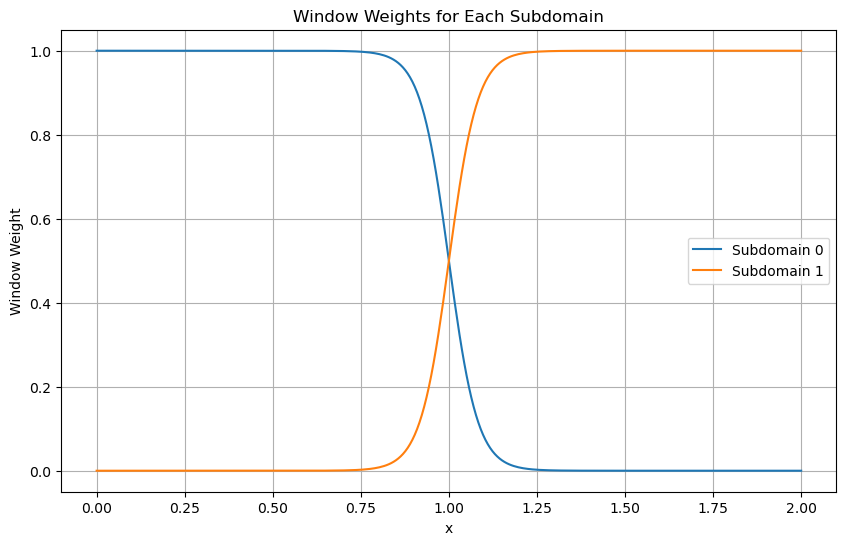

In [4]:
# illustration of window function
x_test = jnp.linspace(0,2, 300)
window_weights_1 = my_window_func(subdomains_list, n_sub, x_test, tol=1e-8)
# plot
plt.figure(figsize=(10, 6))
for i in range(window_weights_1.shape[1]):
    plt.plot(x_test, window_weights_1[:, i], label=f"Subdomain {i}")
plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

In [5]:
key = jax.random.PRNGKey(42)
model_1 = FBPINN(
    key=key,
    num_subdomains=n_sub,
    ansatz=ansatz,
    subdomains=subdomains_list,  
    mlp_config=mlp_config
)
subdomain_collocation_points_uniform, global_collocation_points_uniform = generate_collocation_points(
domain=domain,
subdomains_list=subdomains_list,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)

In [6]:
# test
x_test = jnp.linspace(domain[0], domain[1], 300)
# train
model_1, loss_hist, (t_steps, t_l1) = train_fbpinn(
    model=model_1,
    subdomain_collocation_points=subdomain_collocation_points_uniform,
    steps=steps,
    lr=lr,
    pde_residual_loss=pde_residual_loss,
    x_test=x_test,
    u_exact=u_exact,
    save_dir=None,
    checkpoint_every=0
)


FBPINN: 100%|██████████| 20000/20000 [05:37<00:00, 59.31it/s, l1=3.46e-01, loss=1.68e+03] 


In [7]:
# Plot
u_pred_uniform = jax.vmap(model_1)(x_test).squeeze()
u_true = u_exact(x_test)

In [8]:
def plot_fbpinn_summary(x_test, u_true, u_pred,
                                  train_loss, test_steps, test_l1,
                                  model):
    """Just to display all core visualizations in one figure."""

    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    axs = axs.flatten()

    # 1. Prediction vs Exact
    axs[0].plot(x_test, u_pred, label="Predicted")
    axs[0].plot(x_test, u_true, "--", label="Exact")
    axs[0].set_title("Prediction vs Exact")
    axs[0].legend()
    axs[0].grid(True)

    # 2. Training loss
    axs[1].plot(train_loss, label="Train Loss")
    axs[1].set_title("Training Loss (Log Scale)")
    axs[1].set_yscale("log")
    axs[1].legend()
    axs[1].grid(True)

    # 3. L1 error curve
    axs[2].plot(test_steps, test_l1, label="L1 Error")
    axs[2].set_title("Test L1 Error Curve")
    axs[2].set_yscale("log")
    axs[2].set_xlabel("Step")
    axs[2].set_ylabel("L1")
    axs[2].legend()
    axs[2].grid(True)

    # 4. Subdomain partials
    n_sub = len(model.subnets)
    for i in range(n_sub):
        partial_solution_i = jax.vmap(lambda x: model.subdomain_pred(i, x))(x_test).squeeze()
        window_i = model.subdomain_window(i, x_test)
        weighted = model.ansatz(x_test, window_i * partial_solution_i)
        axs[3].plot(x_test, weighted, label=f"Subdomain {i}", alpha=0.6)
    axs[3].plot(x_test, u_true, "--", color="black", label="Exact", linewidth=2)
    axs[3].set_title("Subdomain Partial Predictions")
    axs[3].legend(fontsize=8, ncol=2)
    axs[3].grid(True)

    plt.tight_layout()
    plt.show()


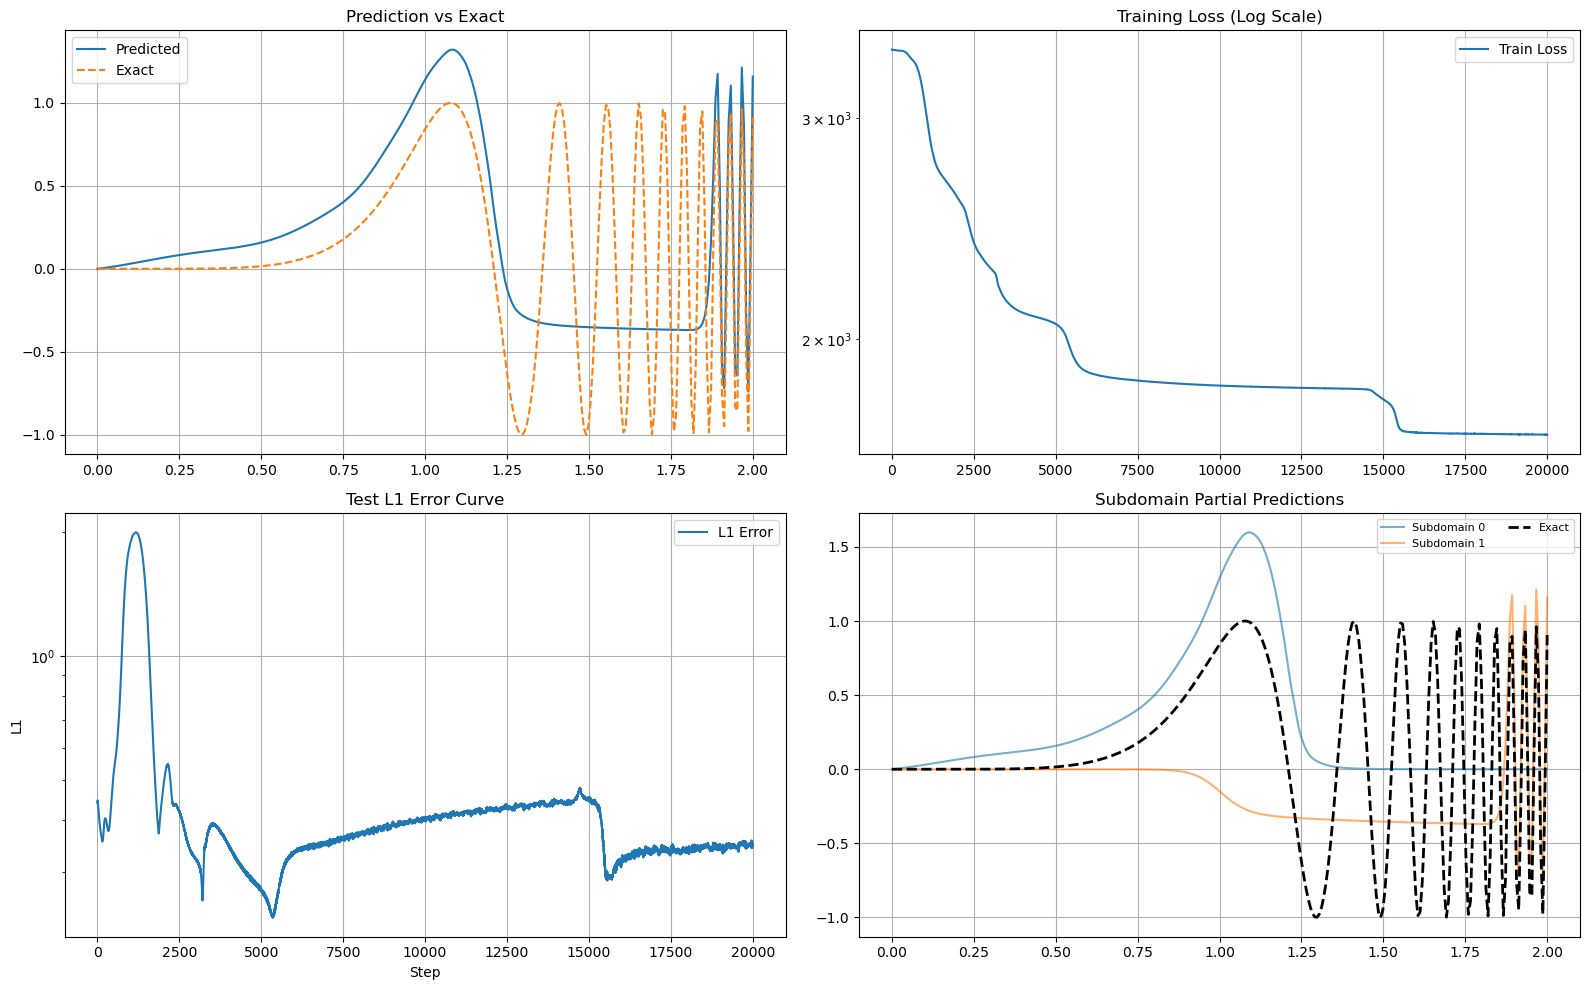

In [9]:
plot_fbpinn_summary(
    x_test=x_test,
    u_true=u_true,
    u_pred=u_pred_uniform,
    train_loss=loss_hist,
    test_steps=t_steps,
    test_l1=t_l1,
    model=model_1
)


### Not uniform
n_sub = 2

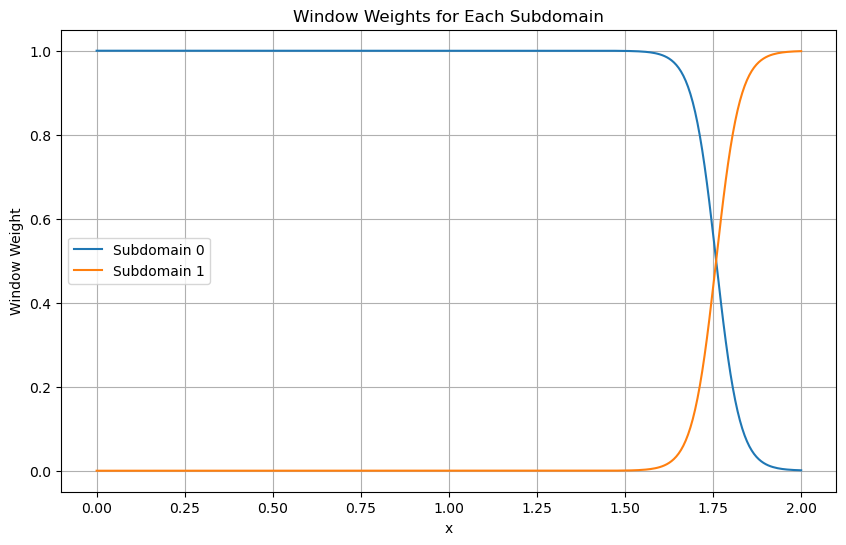

In [10]:
subdomain_list_not_uniform = [(-1.0, 3.0), (1.2, 3.0)]
# illustration of window function
x_test = jnp.linspace(0, 2, 300)
window_weights_not_uniform = my_window_func(subdomain_list_not_uniform, n_sub, x_test, tol=1e-8)
# plot
plt.figure(figsize=(10, 6))
for i in range(window_weights_not_uniform.shape[1]):
    plt.plot(x_test, window_weights_not_uniform[:, i], label=f"Subdomain {i}")
plt.xlabel('x')
plt.ylabel('Window Weight')
plt.legend()
plt.title('Window Weights for Each Subdomain')
plt.grid(True)
plt.show()

In [11]:
key = jax.random.PRNGKey(42)
model_2 = FBPINN(
    key=key,
    num_subdomains=n_sub,
    ansatz=ansatz,
    subdomains=subdomain_list_not_uniform,  
    mlp_config=mlp_config
)
subdomain_collocation_points_not_uniform, global_collocation_points_not_uniform = generate_collocation_points(
domain=domain,
subdomains_list=subdomain_list_not_uniform,
n_points_per_subdomain=n_points_per_subdomain,
seed=0
)

In [12]:
# test
x_test = jnp.linspace(domain[0], domain[1], 300)
# train
model_2, loss_hist_2, (t_steps_2, t_l1_2) = train_fbpinn(
    model=model_2,
    subdomain_collocation_points=subdomain_collocation_points_not_uniform,
    steps=steps,
    lr=lr,
    pde_residual_loss=pde_residual_loss,
    x_test=x_test,
    u_exact=u_exact,
    save_dir=None,
    checkpoint_every=0
)


FBPINN: 100%|██████████| 20000/20000 [05:51<00:00, 56.98it/s, l1=3.15e-02, loss=5.81e+00] 


In [13]:
# Plot
u_pred_not_uniform = jax.vmap(model_2)(x_test).squeeze()
u_true = u_exact(x_test)


In [14]:
print("u_pred shape:", u_pred_not_uniform.shape)
print("u_true shape:", u_true.shape)


u_pred shape: (300,)
u_true shape: (300,)


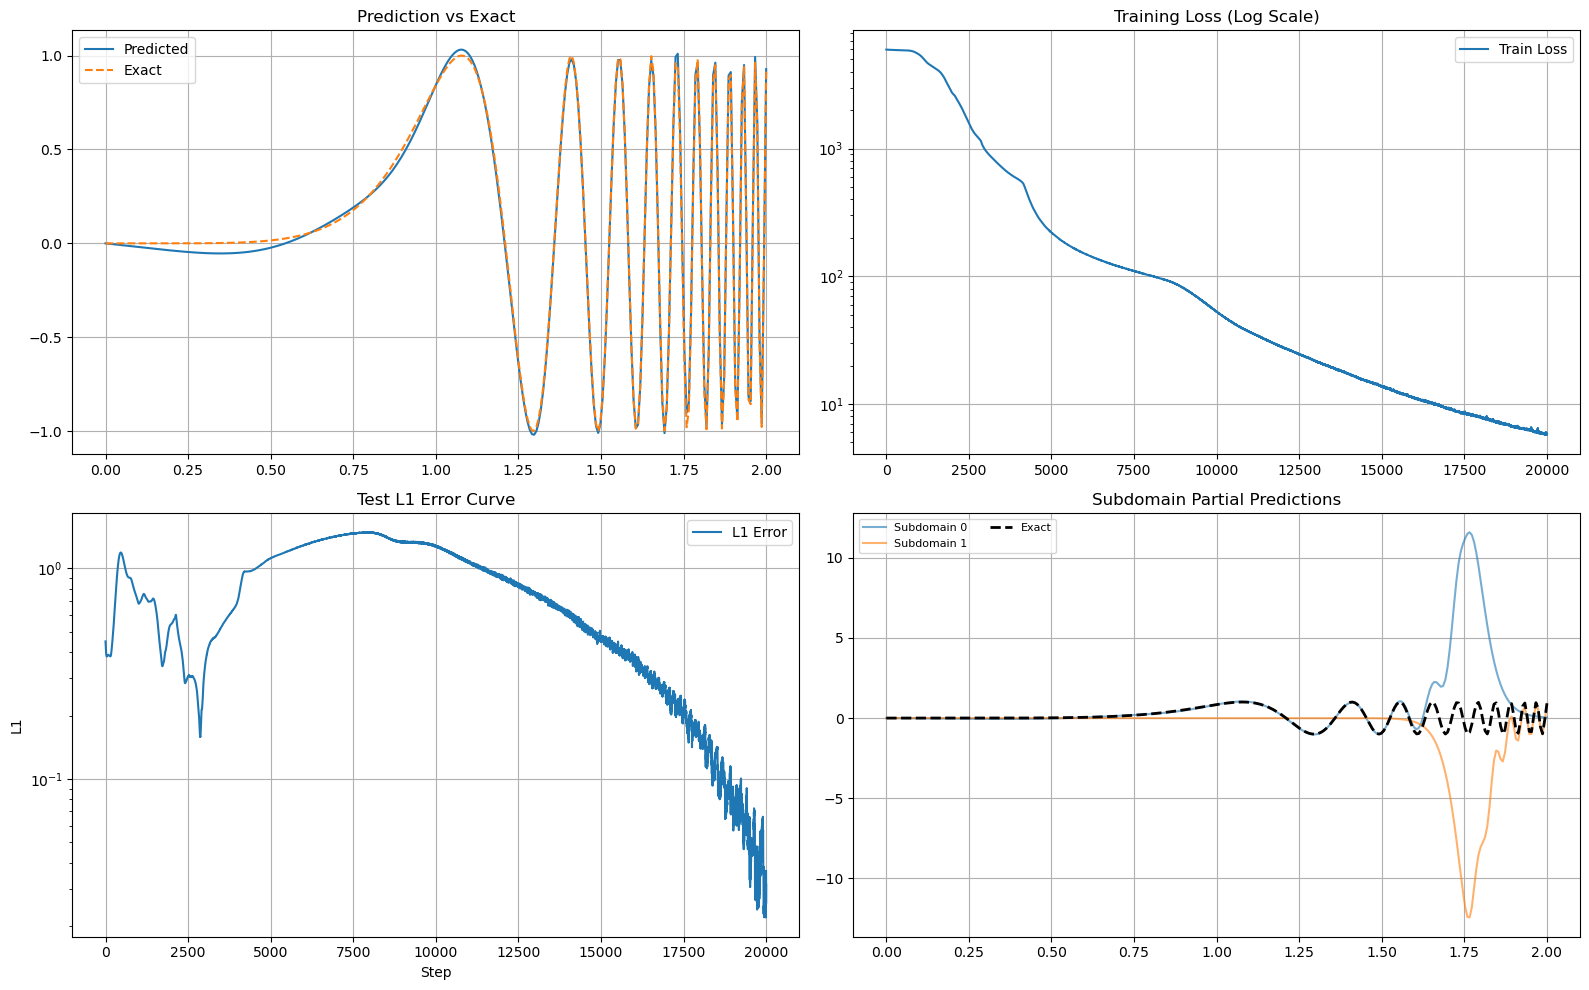

In [15]:
plot_fbpinn_summary(
    x_test=x_test,
    u_true=u_true,
    u_pred=u_pred_not_uniform,
    train_loss=loss_hist_2,
    test_steps=t_steps_2,
    test_l1=t_l1_2,
    model=model_2
)


In [18]:
def plot_loss_and_l1_comparison(train_loss_1, train_loss_2,
                                test_steps, test_l1_1, test_l1_2,u_pred_uniform, u_pred_not_uniform, u_true,
                                label_1="Uniform", label_2="Self-defined"):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Training Loss
    axs[0].plot(train_loss_1, label=label_1)
    axs[0].plot(train_loss_2, label=label_2)
    axs[0].set_title("Training Loss")
    axs[0].set_yscale("log")
    axs[0].set_xlabel("Step")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # Test L1 Error
    axs[1].plot(test_steps, test_l1_1, label=label_1)
    axs[1].plot(test_steps, test_l1_2, label=label_2)
    axs[1].set_title("Test L1 Error")
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("L1 Error")
    axs[1].legend()
    axs[1].grid(True)

    # u_pred vs exact solution

    axs[2].plot(x_test, u_pred_uniform, '--', label="Uniform")
    axs[2].plot(x_test, u_pred_not_uniform, ':', label="Self-defined")
    axs[2].plot(x_test, u_true, label="Exact", linewidth=1)
    axs[2].set_title("Prediction vs Exact Solution")
    axs[2].set_xlabel("x")
    axs[2].set_ylabel("u(x)")
    axs[2].legend()
    axs[2].grid(True)
    plt.tight_layout()
    plt.show()


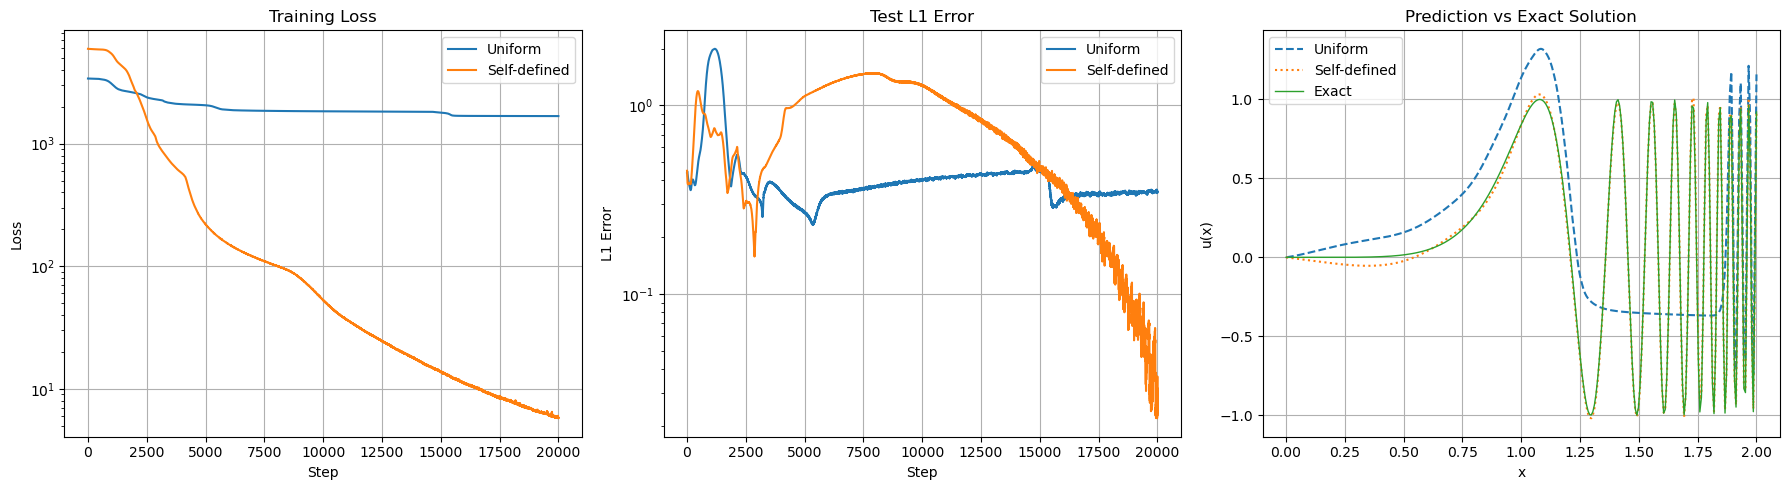

In [19]:
plot_loss_and_l1_comparison(
    train_loss_1= loss_hist,
    train_loss_2= loss_hist_2,
    test_steps= t_steps,
    test_l1_1=t_l1,
    test_l1_2=t_l1_2,
    u_pred_uniform=u_pred_uniform,
    u_pred_not_uniform=u_pred_not_uniform,
    u_true=u_true,
    label_1="Uniform",
    label_2="Self-defined"
)
